# A/B Testing with BayesAB

We’ll walk through two examples. One Bernoulli random variable modeling click-through-rate onto a page, and one Poisson random variable modeling the number of selections one makes once on that page. 

Let’s say we are testing two versions of Page 1, to see the CTR onto Page 2. For this example, we’ll just simulate some data with the properties we desire.

In [1]:
# import library
library(bayesAB)

### Data

In [2]:
# simulate the data
A_binom <- rbinom(250, 1, .25)
B_binom <- rbinom(250, 1, .2)

In [8]:
print(summary(A_binom))
print(summary(B_binom))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   0.000   0.000   0.252   0.750   1.000 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   0.000   0.000   0.156   0.000   1.000 


### Prior

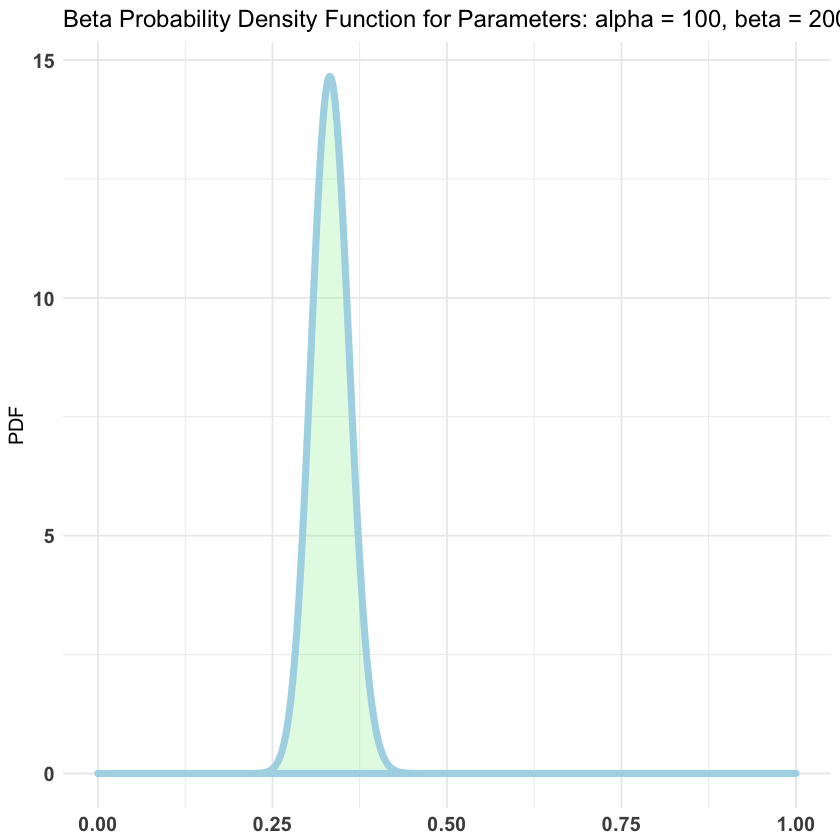

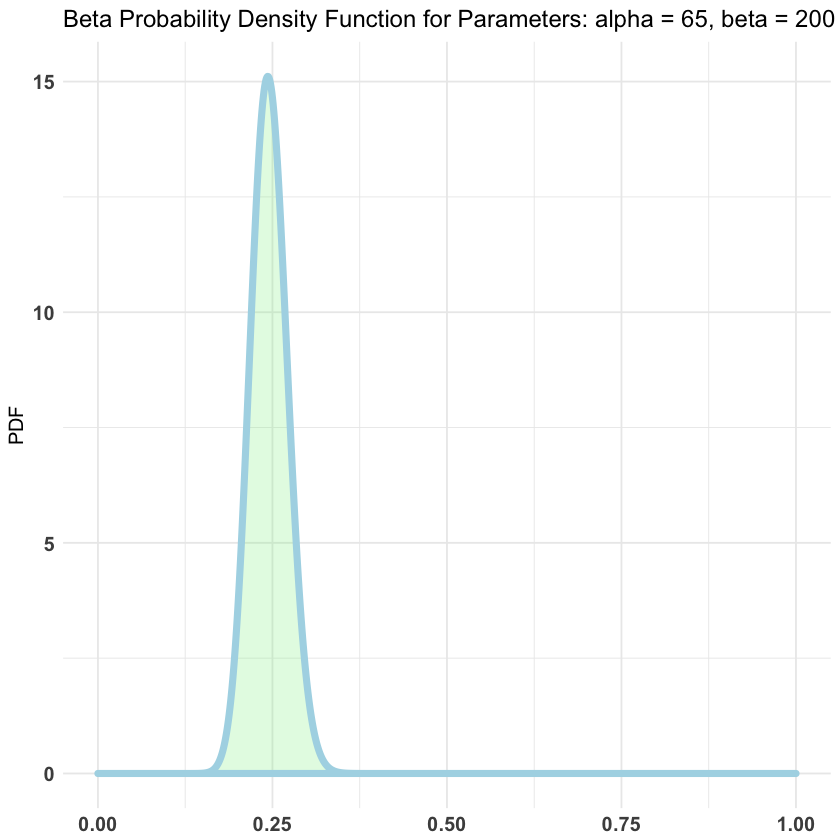

In [10]:
# conjugate prior for the Bernoulli distribution is the Beta distribution
plotBeta(100, 200) # looks a bit off
plotBeta(65, 200) # perfect

Now that we’ve settled on a prior, let’s fit our bayesTest object.

In [14]:
# Fit bernoulli and normal tests
AB1 <- bayesTest(A_binom, B_binom, 
                 priors = c('alpha' = 65, 'beta' = 200), 
                 n_samples = 1e5, 
                 distribution = 'bernoulli')

In [15]:
# check model
print(AB1)

--------------------------------------------
Distribution used: bernoulli 
--------------------------------------------
Using data with the following properties: 
            A     B
Min.    0.000 0.000
1st Qu. 0.000 0.000
Median  0.000 0.000
Mean    0.252 0.156
3rd Qu. 0.750 0.000
Max.    1.000 1.000
--------------------------------------------
Conjugate Prior Distribution: Beta 
Conjugate Prior Parameters: 
$alpha
[1] 65

$beta
[1] 200

--------------------------------------------
Calculated posteriors for the following parameters: 
Probability 
--------------------------------------------
Monte Carlo samples generated per posterior: 
[1] 1e+05


In [17]:
# summarize model
summary(AB1)

Quantiles of posteriors for A and B:

$Probability
$Probability$A
       0%       25%       50%       75%      100% 
0.1738077 0.2355895 0.2482634 0.2612589 0.3405204 

$Probability$B
       0%       25%       50%       75%      100% 
0.1349173 0.1898536 0.2016476 0.2137391 0.2875748 


--------------------------------------------

P(A > B) by (0)%: 

$Probability
[1] 0.96357

--------------------------------------------

Credible Interval on (A - B) / B for interval length(s) (0.9) : 

$Probability
        5%        95% 
0.01711968 0.49659148 

--------------------------------------------

Posterior Expected Loss for choosing B over A:

$Probability
[1] 0.001775743


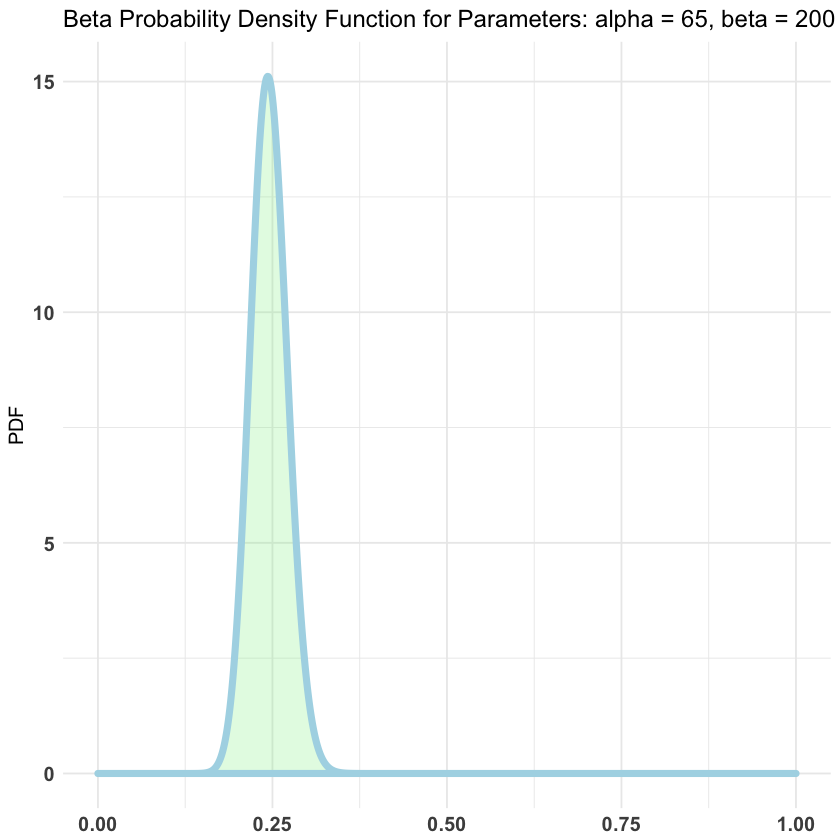

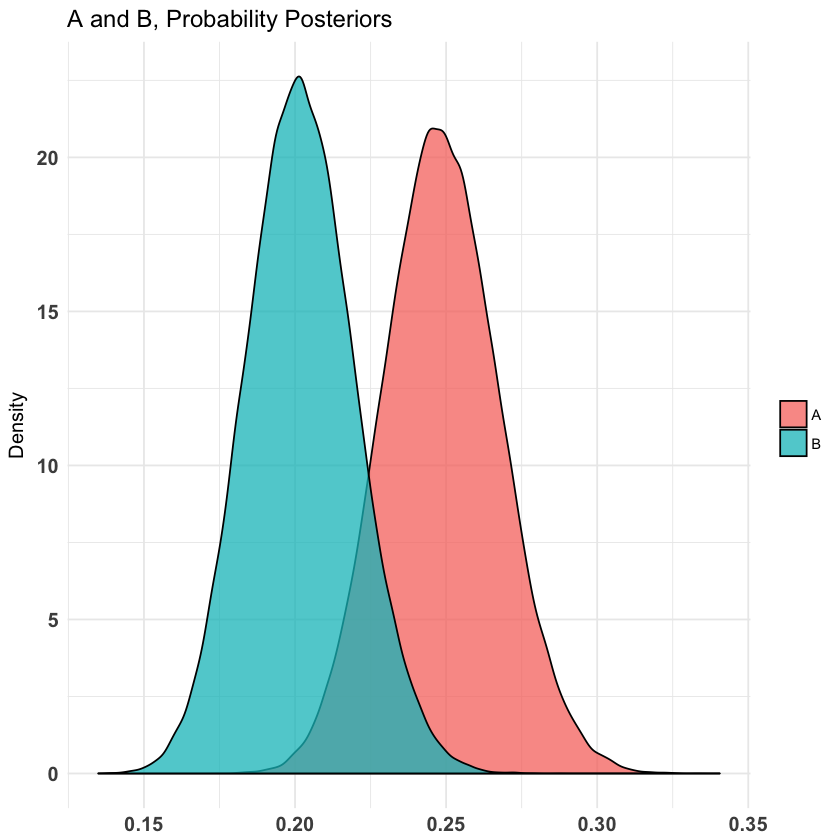

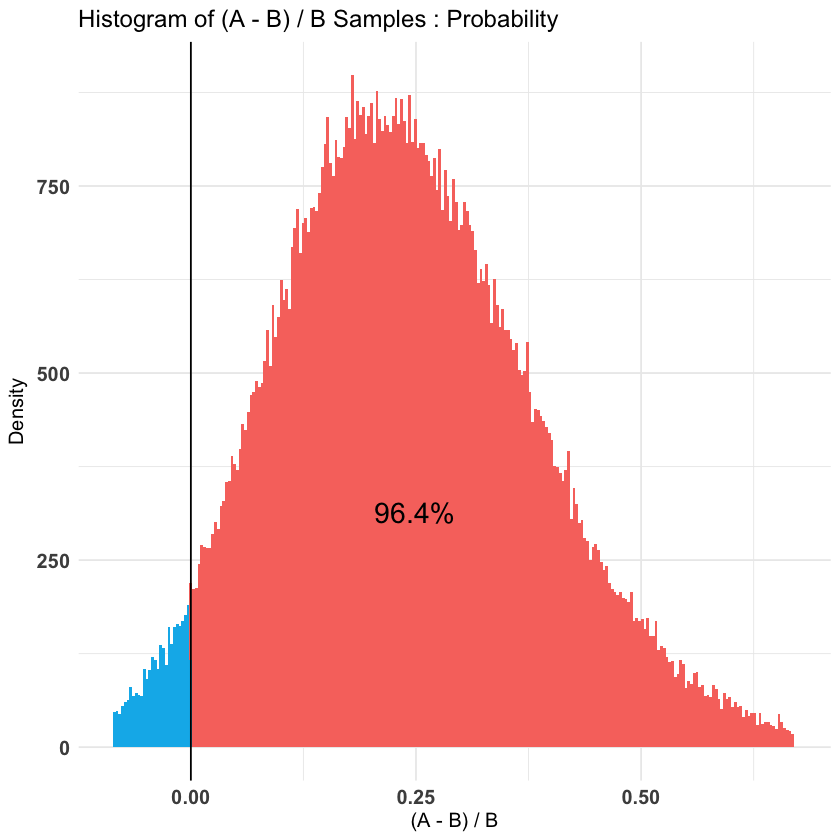

In [18]:
# plot model
plot(AB1)

Now we are on Page 2. On Page 2 you have any number of ‘interactions’ one can make. Let’s say we wish to parametrize the amount of ‘interactions’ a user has by the Poisson distribution. Let’s also say, our priors would have us believe that the bulk of users will make between 5-6 interactions but we aren’t too sure on that number so we will allow a reasonable probability for other values. The conjugate prior for the Poisson distribution is the Gamma distribution.

### Data

In [19]:
# simulate the data
A_pois <- rpois(250, 6.5)
B_pois <- rpois(250, 5.5)

## Prior

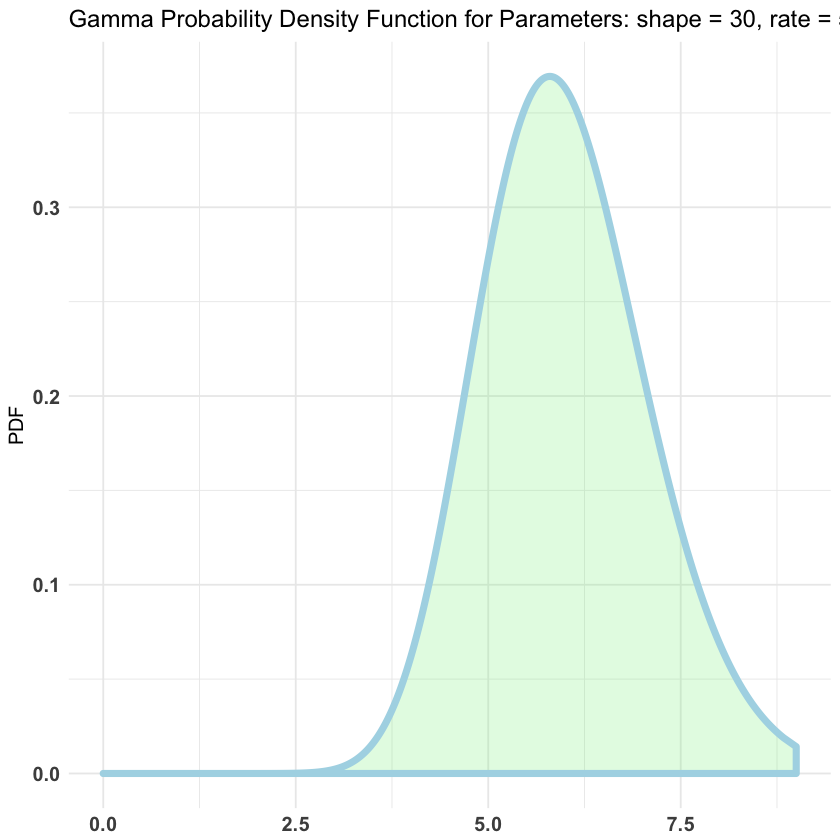

In [20]:
# plot prior
plotGamma(30, 5) # 5-6 seem likely enough

In [22]:
AB2 <- bayesTest(A_pois, B_pois, 
                 priors = c('shape' = 30, 'rate' = 5), 
                 n_samples = 1e5, 
                 distribution = 'poisson')

In [24]:
# check the model
print(AB2)

--------------------------------------------
Distribution used: poisson 
--------------------------------------------
Using data with the following properties: 
             A      B
Min.     0.000  1.000
1st Qu.  5.000  4.000
Median   7.000  6.000
Mean     7.024  5.596
3rd Qu.  8.000  7.000
Max.    16.000 12.000
--------------------------------------------
Conjugate Prior Distribution: Gamma 
Conjugate Prior Parameters: 
$shape
[1] 30

$rate
[1] 5

--------------------------------------------
Calculated posteriors for the following parameters: 
Lambda 
--------------------------------------------
Monte Carlo samples generated per posterior: 
[1] 1e+05


In [25]:
# summarize the model
summary(AB2)

Quantiles of posteriors for A and B:

$Lambda
$Lambda$A
      0%      25%      50%      75%     100% 
6.318010 6.890796 7.001909 7.114896 7.716244 

$Lambda$B
      0%      25%      50%      75%     100% 
4.991570 5.503753 5.603207 5.703900 6.290574 


--------------------------------------------

P(A > B) by (0)%: 

$Lambda
[1] 1

--------------------------------------------

Credible Interval on (A - B) / B for interval length(s) (0.9) : 

$Lambda
       5%       95% 
0.1790292 0.3251204 

--------------------------------------------

Posterior Expected Loss for choosing B over A:

$Lambda
[1] 0


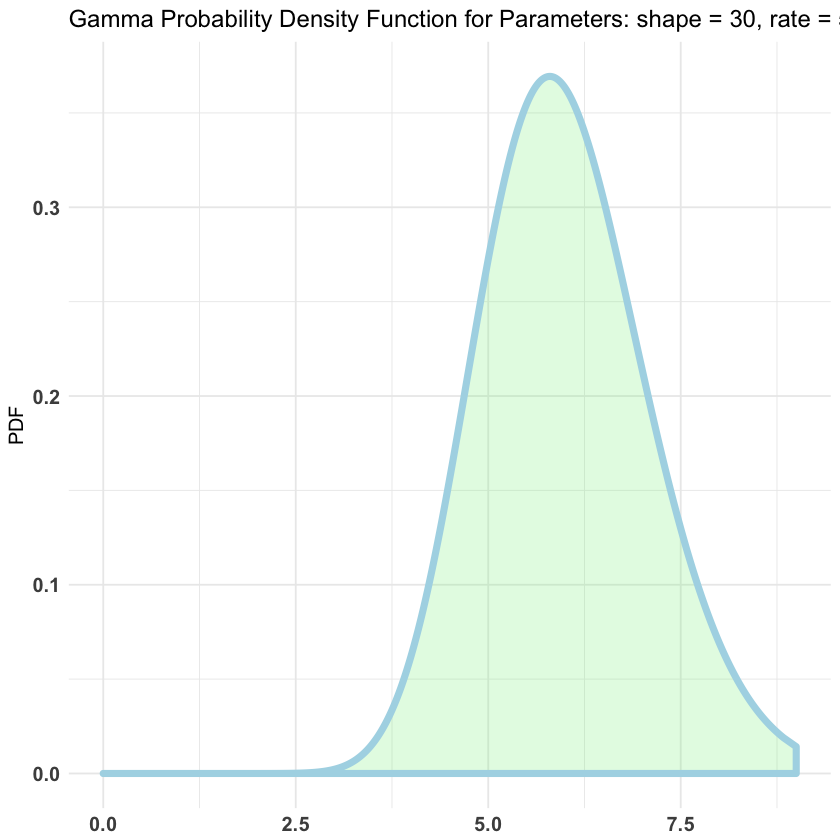

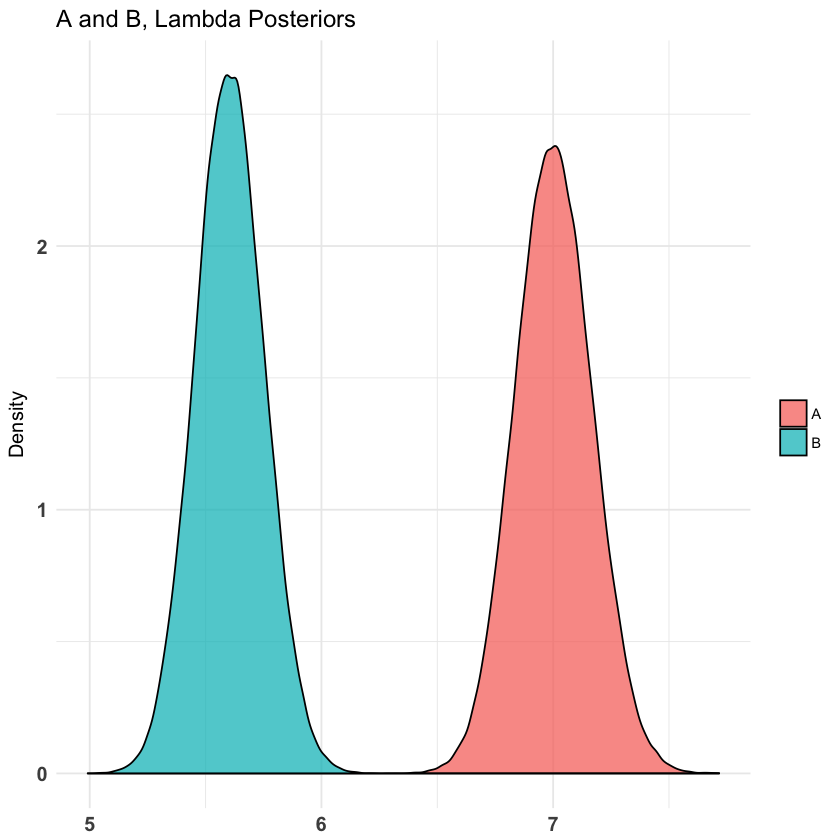

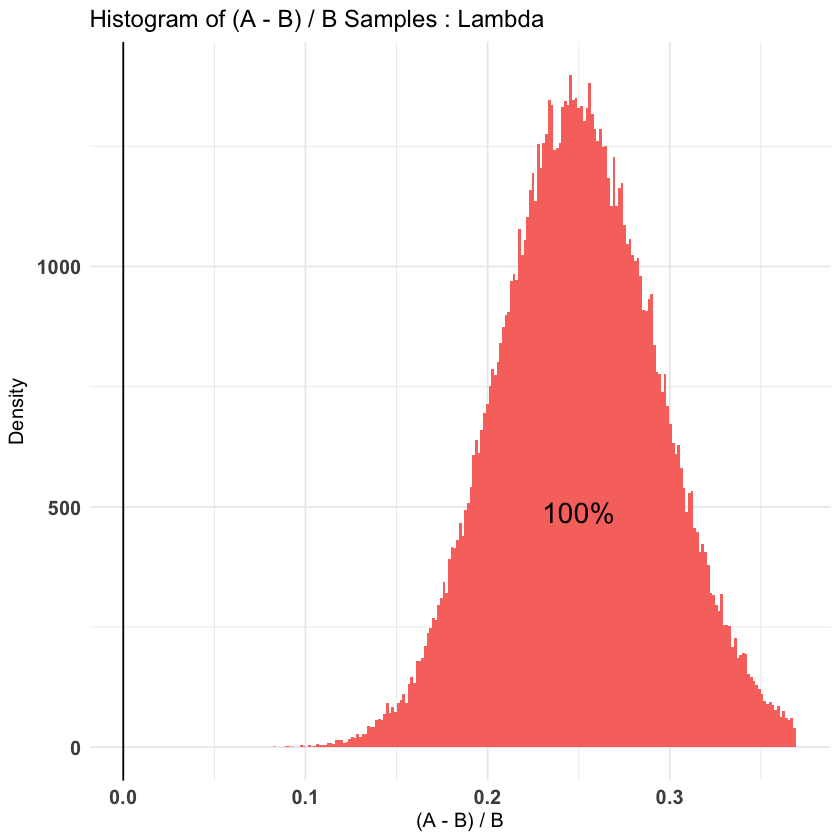

In [26]:
# plot model
plot(AB2)

### Combining Distribution

Another feature of bayesAB is the ability to decompose your end distribution into a series of intermediate distributions which are easier to parametrize. For example, let’s take the above example and say we want to test the effect of JUST Page 1 on Page 2’s interactions. Sure, we can try to come up with a way to parametrize the behaviors on Page 2 in the context of the conversion from Page 1, but isn’t it easier to encapsulate both parts as their own random variables, with their own informed priors from past traffic data. Using the combine function in bayesAB we can make this possible. Let’s consider the same test objects we have already fit. 

In [27]:
# A combined object would look like this
AB3 <- combine(AB1, AB2, 
               f = `*`, 
               params = c('Probability', 'Lambda'), 
               newName = 'Expectation')

In [28]:
# also equivalent with %>% if you like piping
library(magrittr)
AB3 <- AB1 %>%
  combine(AB2, f = `*`, params = c('Probability', 'Lambda'), newName = 'Expectation')

For the combined distribution, we use the * function (multiplication) since each value of the Poisson distribution for Page 2 is multiplied by the corresponding probability of landing on Page 2 from Page 1 in the first place. The resulting distribution can be thought of as the ‘Expected number of interactions on Page 2’ so we have chosen the name ‘Expectation’. The class of bayesTest is idempotent under combine, meaning the resulting object is also a bayesTest. That means the same generics apply.

In [29]:
# check combined model
print(AB3)

--------------------------------------------
Distribution used: combined 
--------------------------------------------
Using data with the following properties: 
            A      A     B      B
Min.    0.000  0.000 0.000  1.000
1st Qu. 0.000  5.000 0.000  4.000
Median  0.000  7.000 0.000  6.000
Mean    0.252  7.024 0.156  5.596
3rd Qu. 0.750  8.000 0.000  7.000
Max.    1.000 16.000 1.000 12.000
--------------------------------------------
Conjugate Prior Distribution:  
Conjugate Prior Parameters: 
[1] "Combined distributions have no priors. Inspect each element separately for details."
--------------------------------------------
Calculated posteriors for the following parameters: 
Expectation 
--------------------------------------------
Monte Carlo samples generated per posterior: 
[1] 1e+05


In [30]:
# summarize the model
summary(AB3)

Quantiles of posteriors for A and B:

$Expectation
$Expectation$A
      0%      25%      50%      75%     100% 
1.224656 1.645468 1.738282 1.833625 2.436357 

$Expectation$B
       0%       25%       50%       75%      100% 
0.7402379 1.0602215 1.1295459 1.2004185 1.6169487 


--------------------------------------------

P(A > B) by (0)%: 

$Expectation
[1] 0.99982

--------------------------------------------

Credible Interval on (A - B) / B for interval length(s) (0.9) : 

$Expectation
       5%       95% 
0.2600883 0.8852241 

--------------------------------------------

Posterior Expected Loss for choosing B over A:

$Expectation
[1] 6.394815e-06


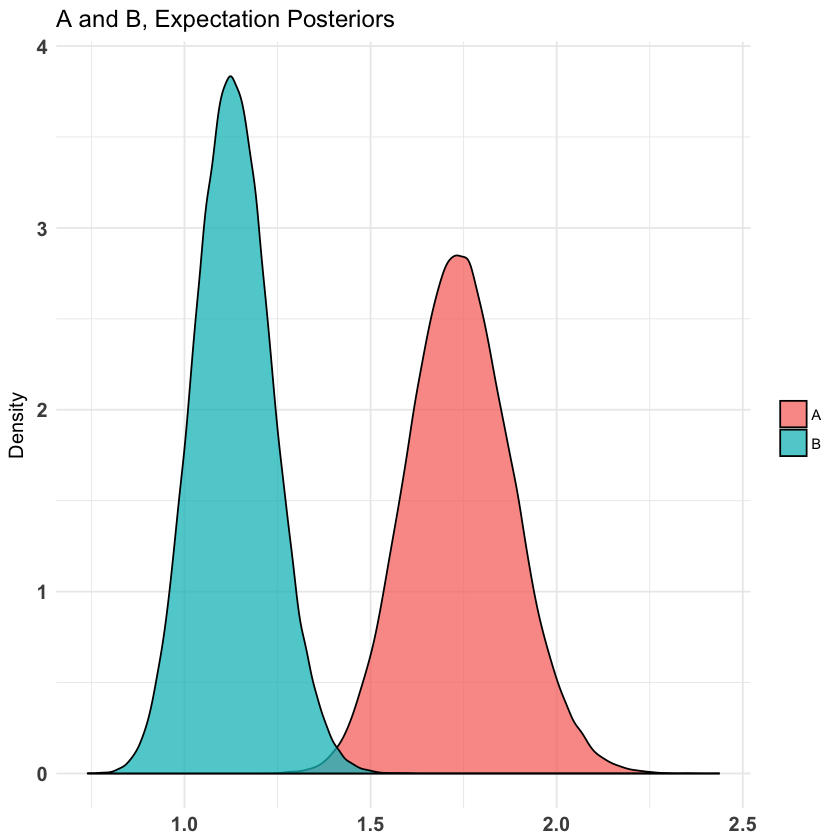

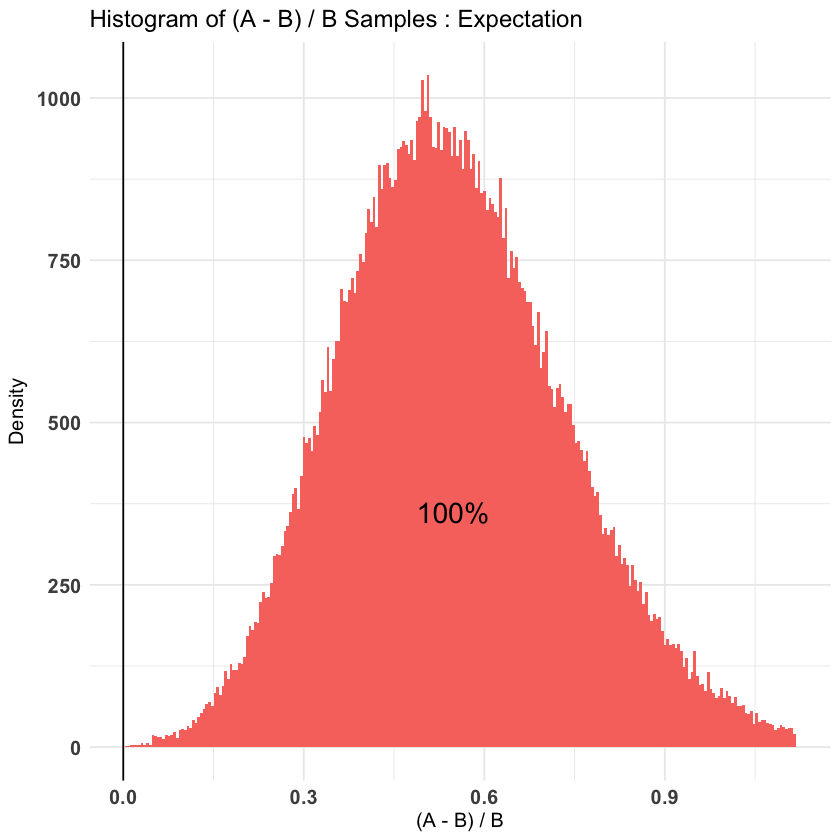

In [31]:
# plot the model
plot(AB3)

Even without good and/or strong priors there are still ways to control for false positives and all that good stuff. We use something called Expected Posterior Loss or “based on the current winner, what is the expected loss you would see should you choose wrongly”. If this value is lower than your threshold of caring (abs(A - b)) then you can go ahead and call your test. This value implictly encompasses the uncertainty about your posteriors.

In [32]:
# he strong and weak priors will be centered around this value of 2.3.
n <- 1e3
out_weaker_priors <- rep(NA, n)
out_stronger_priors <- rep(NA, n)
out_diffuse <- rep(NA, n)

getProb <- function(x) summary(x)$probability$Lambda

for(i in 1:n) {
  A <- rpois(100, 2.3)
  B <- rpois(100, 2.3)

  out_weaker_priors[i] <- bayesTest(A, B, priors = c('shape' = 23, 'rate' = 10), 
                                    distribution = 'poisson') %>%
    getProb

  out_stronger_priors[i] <- bayesTest(A, B, priors = c('shape' = 230, 'rate' = 100), 
                                      distribution = 'poisson') %>%
    getProb

  out_diffuse[i] <- bayesTest(A, B, priors = c('shape' = 0.00001, 'rate' = 0.00001), 
                              distribution = 'poisson') %>%
    getProb
}

out_weaker_priors <- ifelse(out_weaker_priors <= 0.05 | out_weaker_priors >= .95, 1, 0)
out_stronger_priors <- ifelse(out_stronger_priors <= 0.05 | out_stronger_priors >= .95, 1, 0)
out_diffuse <- ifelse(out_diffuse <= 0.05 | out_diffuse >= .95, 1, 0)

Now, A and B shouldn’t have any difference between the two but occasionally we will see a Type 1 error. That’s what the bottom 3 lines are doing. If P(A > B) is <=0.05 or >= .95 we call one of the recipes “significantly” better. Observe what happens with each case of prior.

In [33]:
mean(out_weaker_priors)

[1] 0.091

In [35]:
mean(out_stronger_priors)

[1] 0.023

In [36]:
mean(out_diffuse)

[1] 0.113

The diffuse priors have the most Type 1 errors, followed by the weak priors, followed by the strong priors (to be expected).

Finally, we can fit another bayesTest (:D) to determine whether the differences between Type 1 error percents across priors are different from one another.

In [38]:
t1 <- bayesTest(out_diffuse, out_weaker_priors,
                priors = c('alpha' = 1, 'beta' = 1), 
                distribution = 'bernoulli')
t2 <- bayesTest(out_diffuse, out_stronger_priors, 
                priors = c('alpha' = 1, 'beta' = 1), 
                distribution = 'bernoulli')

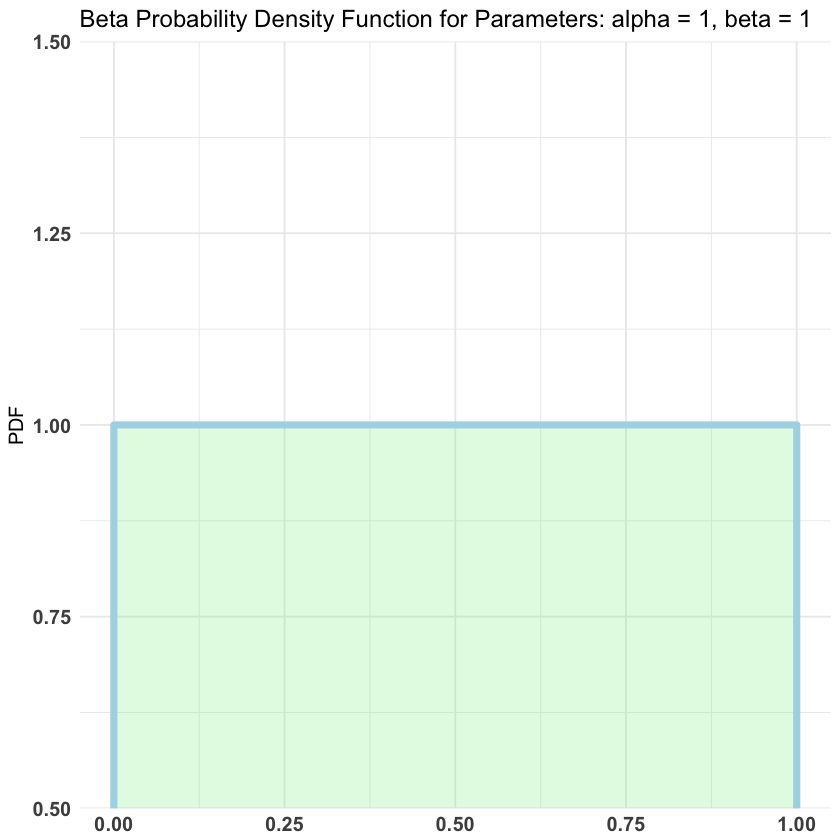

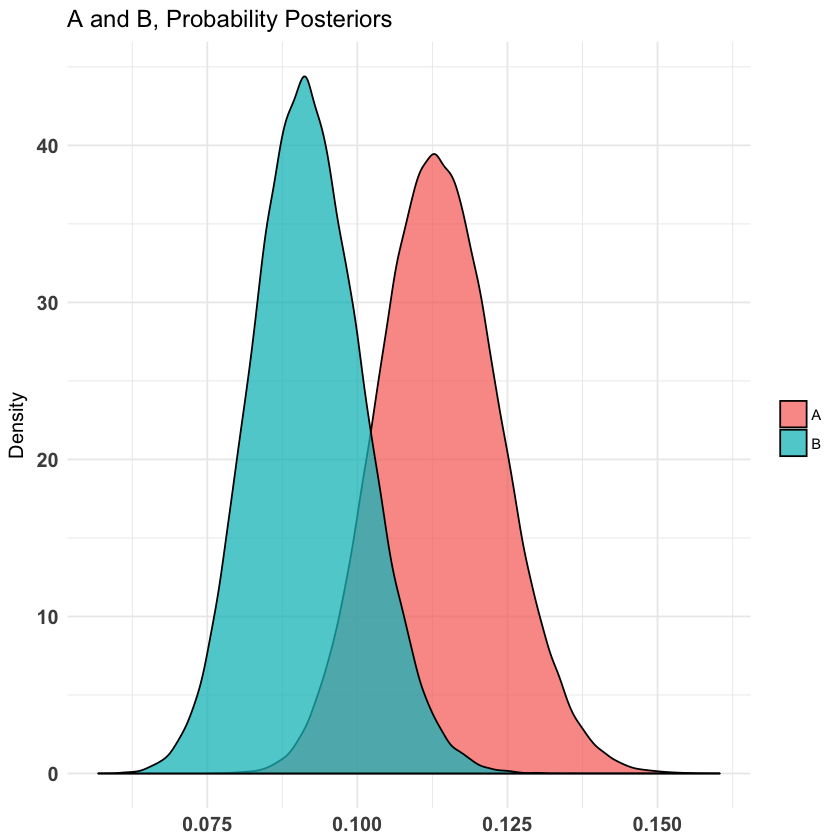

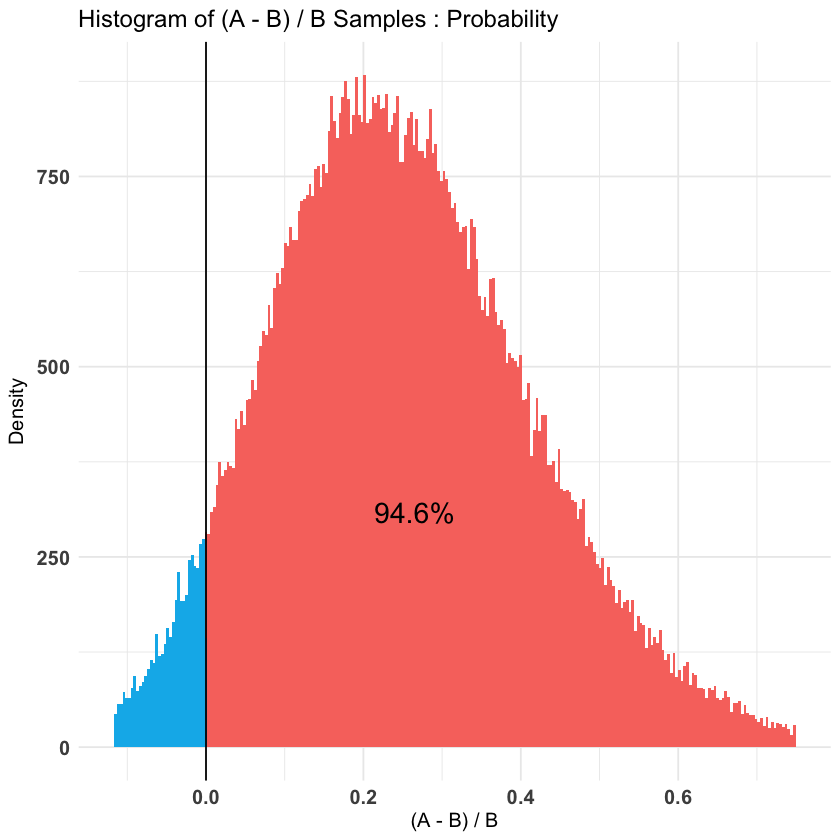

In [39]:
# with priors
plot(t1)

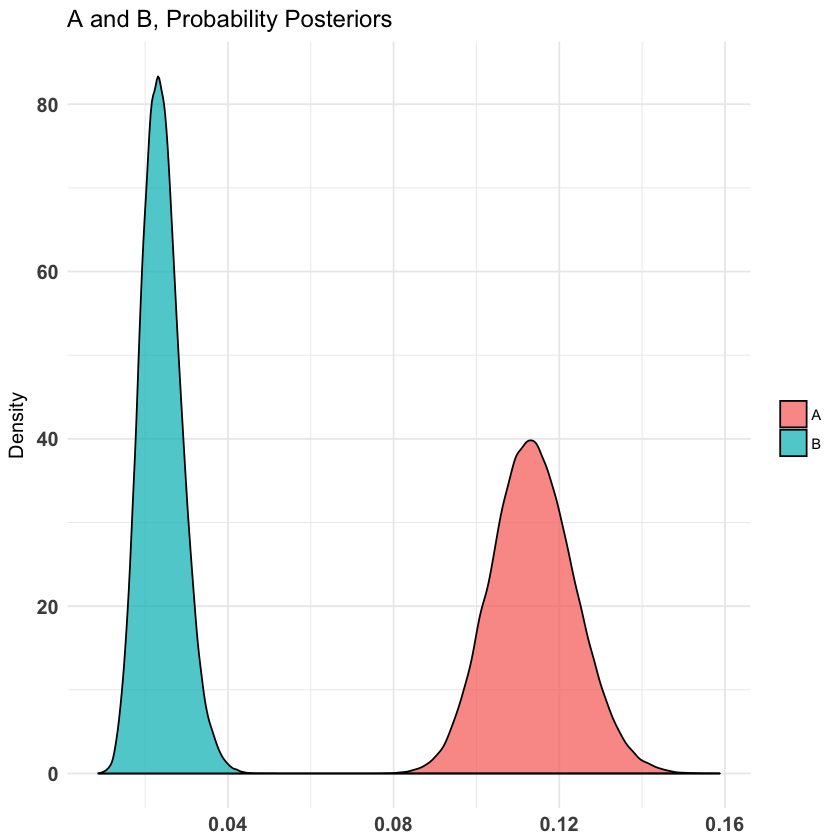

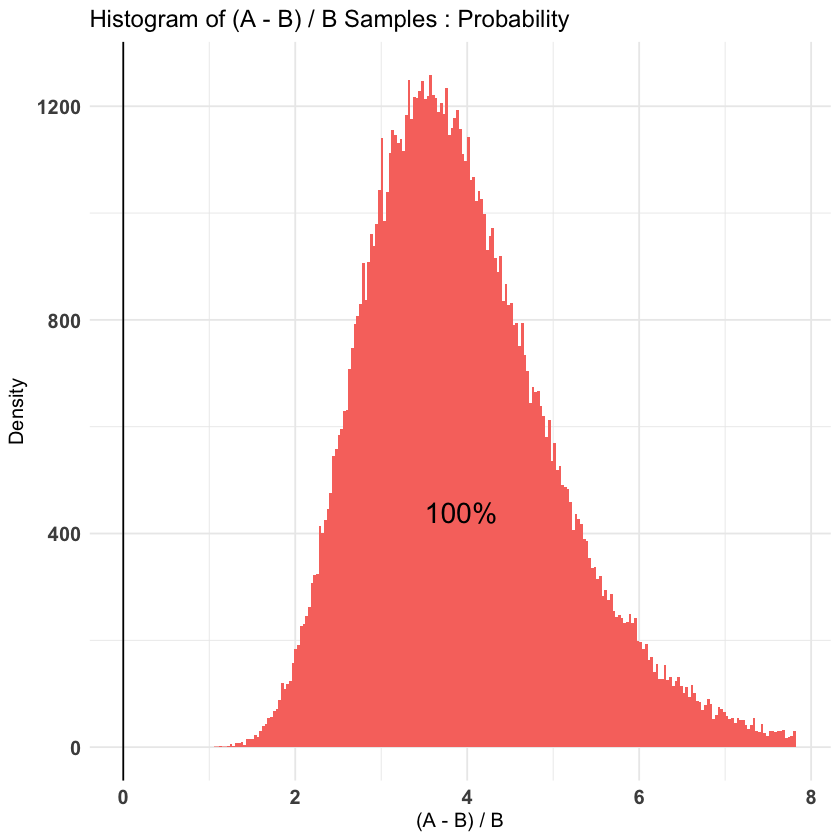

In [40]:
# with no priors
plot(t2, priors = FALSE)

In [41]:
# Finally we can check the output of summary to see 
# if the Posterior Expected Loss is within our constraints.
summary(t1)

Quantiles of posteriors for A and B:

$Probability
$Probability$A
        0%        25%        50%        75%       100% 
0.07552244 0.10677392 0.11346942 0.12041461 0.16033434 

$Probability$B
        0%        25%        50%        75%       100% 
0.05685849 0.08552746 0.09154146 0.09789132 0.13595932 


--------------------------------------------

P(A > B) by (0)%: 

$Probability
[1] 0.94613

--------------------------------------------

Credible Interval on (A - B) / B for interval length(s) (0.9) : 

$Probability
          5%          95% 
-0.004666441  0.547175448 

--------------------------------------------

Posterior Expected Loss for choosing B over A:

$Probability
[1] 0.003149336


In [42]:
summary(t2)

Quantiles of posteriors for A and B:

$Probability
$Probability$A
        0%        25%        50%        75%       100% 
0.07598022 0.10685772 0.11347963 0.12036584 0.15870735 

$Probability$B
         0%         25%         50%         75%        100% 
0.008720552 0.020525621 0.023627705 0.026989920 0.051251018 


--------------------------------------------

P(A > B) by (0)%: 

$Probability
[1] 1

--------------------------------------------

Credible Interval on (A - B) / B for interval length(s) (0.9) : 

$Probability
      5%      95% 
2.384951 6.028040 

--------------------------------------------

Posterior Expected Loss for choosing B over A:

$Probability
[1] 0


If the Posterior Expected Loss is lower than our threshold for caring on abs(A - B) then we can call this test and accept the current results. it’s quite clear that priors, even weak ones, have a significant positive effect on Type 1 Errors. Remember that we see this effect partially because our priors were of a similar shape to the data. If the priors and the data disagree, the effects might not be so clear cut and you will need more data to have a stable posterior.

## Conclusion

Case study was meant to be a view of A/B testing in a Bayesian light using the bayesAB library.